In [1]:
import torch
import numpy as np
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_prob_atlas
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
import nibabel as nib
from tqdm import trange
import scipy
import matplotlib.pyplot as plt

import os

from model import SpatialActivation, SAEncoder
from utils import IoU, inverse_transform, transform2d, thresholding
from baseline.glm import GLM
from baseline.masker import Masker

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/lyh/anaconda3/envs/torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
if not os.path.exists("./data/hcp/gambling/"):
    os.mkdir("./data/hcp/gambling/")

In [3]:
class GroupwiseAnalysis:
    def __init__(self, mask_path="/media/lyh/6266CBD166CBA45F/data/HCP_data/mask_152_4mm.nii.gz", 
                 device="cuda", model_path="./model/hcp_gambling_1.pth", batch_size=1,
                 template_path="/media/lyh/6266CBD166CBA45F/data/template/GAMBLING_maps.npy",
                 task_design_path="/media/lyh/6266CBD166CBA45F/data/HCP_data/design/gambling/design.mat"):
        self.masker = Masker(mask_path=mask_path)
        self.device = device
        self.load_encoder(model_path)
        self.load_template(template_path, task_design_path)
        self.batch_size = batch_size
        self.buffer_1 = np.zeros((self.task_design.shape[0], 28546))
        self.buffer_2 = np.zeros((self.task_design.shape[0], 28546))
        
    def load_encoder(self, model_path):
        model = SpatialActivation()
        model.load_state_dict(torch.load(model_path))
        self.encoder = SAEncoder()
        self.encoder.load_state_dict(model.sa_encoder.state_dict())
        self.encoder.to(self.device)
        self.encoder.eval()
    
    def load_template(self, template_path, task_design_path):
        self.template_path = template_path
        self.task_design_path = task_design_path
        self.task_design = np.loadtxt(task_design_path, delimiter="\t", skiprows=5, dtype=float, usecols=[0, 2])
        self.template = np.load(self.template_path)[:self.task_design.shape[1], :]
    
    def load_imgs(self, img_path):
        fmri_masked = np.load(img_path)
        x_train_3D = self.masker.inverse_transform(fmri_masked)
        self.img = torch.tensor(x_train_3D, dtype=torch.float)
        del x_train_3D
        self.img = self.img.permute(3, 0, 1, 2)
        self.img = self.img.unsqueeze(1)
        self.len = self.img.shape[0]
        
    def get_group_wise_fbn(self):
        group_step = 16
        for index in range(self.len):
            _, ca, sa = self.encoder(self.img[index:index+1, ...].to(self.device))
            ca = ca.flatten().detach().cpu()
            sa = sa.squeeze(0)
            sa = sa.permute(1, 2, 3, 0).detach().cpu().numpy()
            img2d = self.masker.transform(sa)
            for i in range(0, 32, group_step):
                tmp2d = img2d[i:i+group_step]
                tmpca = ca[i:i+group_step].view(-1, 1)
                tmp2d = torch.tensor(tmp2d, dtype=torch.float)
                tmp2d = torch.sum(tmpca.expand_as(tmp2d) * tmp2d, dim=0).detach().numpy()
                if i < 10:
                    self.buffer_1[index, :] += tmp2d
                else:
                    self.buffer_2[index, :] += tmp2d
#                 tmp2d = (tmp2d - tmp2d.min()) / (tmp2d.max() - tmp2d.min())
#                 tmp2d = tmp2d ** 2
    
    def normalize(self):
        tmp2d_1 = (self.buffer_1 - self.buffer_1.min(axis=1).reshape(self.buffer_1.shape[0], 1)) / \
                (self.buffer_1.max(axis=1).reshape(self.buffer_1.shape[0], 1) - self.buffer_1.min(axis=1).reshape(self.buffer_1.shape[0], 1))
        tmp2d_1 = tmp2d_1 ** 2
        
        tmp2d_2 = (self.buffer_2 - self.buffer_2.min(axis=1).reshape(self.buffer_2.shape[0], 1)) / \
                (self.buffer_2.max(axis=1).reshape(self.buffer_2.shape[0], 1) - self.buffer_2.min(axis=1).reshape(self.buffer_2.shape[0], 1))
        tmp2d_2 = tmp2d_2 ** 2
        return tmp2d_1, tmp2d_2
    
    def plot_net(self):
        tmp2d_1, tmp2d_2 = self.normalize()
        components_img = self.masker.img2NiftImage(tmp2d_1)
        for i, cur_img in enumerate(iter_img(components_img)):
            print(i)
            plot_stat_map(cur_img, display_mode="z", title=None,
                          cut_coords=10, colorbar=1)
            show()
        print("------------------------------------------------")
        components_img = self.masker.img2NiftImage(tmp2d_2)
        for i, cur_img in enumerate(iter_img(components_img)):
            print(i)
            plot_stat_map(cur_img, display_mode="z", title=None,
                          cut_coords=10, colorbar=1)
            show()
        
    def save_net(self, path="./data/hcp/gambling/", num=20):
        np.save(path + "gambling_1_{}.npy".format(num), self.buffer_1)
        np.save(path + "gambling_2_{}.npy".format(num), self.buffer_2)

In [8]:
import os
task_path = ["/media/lyh/6266CBD166CBA45F/data/HCP_data/SINGLE/" + file for file in os.listdir("/media/lyh/6266CBD166CBA45F/data/HCP_data/SINGLE/") if "GAMBLING" in file]

In [9]:
len(task_path)

499

In [6]:
groups = GroupwiseAnalysis()
for i in trange(len(task_path[:40])):
    groups.load_imgs(task_path[i])
    groups.get_group_wise_fbn()
groups.save_net(num=40)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [26:46<00:00, 40.16s/it]


In [10]:
groups = GroupwiseAnalysis()
groups.buffer_1 = np.load("./data/hcp/gambling/gambling_1_40.npy")
groups.buffer_2 = np.load("./data/hcp/gambling/gambling_2_40.npy")

In [11]:
tmp2d_1, tmp2d_2 = groups.normalize()
tmp2d_1.shape

(253, 28546)

In [12]:
tmp2d_1[tmp2d_1<0.55] = 0

In [13]:
template = np.load(groups.template_path)[:groups.task_design.shape[1], :]
template.shape

(2, 28546)

In [14]:
template = thresholding(template)

In [15]:
iou = np.zeros((tmp2d_1.shape[0], template.shape[0]))
for i in range(tmp2d_1.shape[0]):
    for j in range(template.shape[0]):
        iou[i, j] = IoU(template[j:j+1, :], tmp2d_1[i:i+1, :])

1


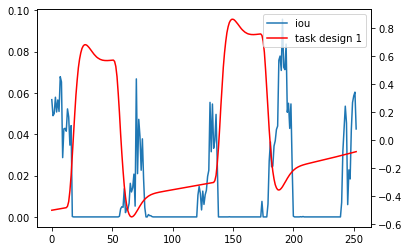

PCC=-0.4168732840220141 p=0.00000
2


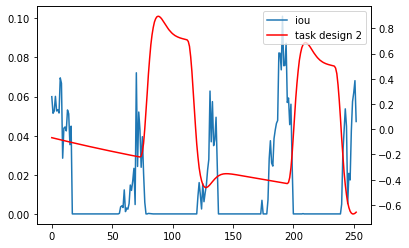

PCC=-0.41896088851717034 p=0.00000


In [16]:
for i in range(iou.shape[1]):
    print(i+1)
    line1, = plt.plot(iou[:, i], label="iou")
    plt.twinx()
    line2, = plt.plot(groups.task_design[:, i], color='red', label="task design {}".format(i+1))
    plt.legend(handles=[line1, line2], loc="upper right", labels=["iou", "task design {}".format(i+1)])
    plt.show()
    corr, p = scipy.stats.pearsonr(iou[:, i], groups.task_design[:, i])
    print("PCC={} p={:.5f}".format(corr, p))

1


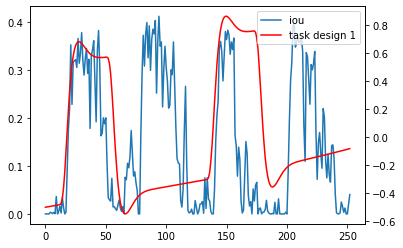

PCC=0.2863710934867678 p=0.00000
2


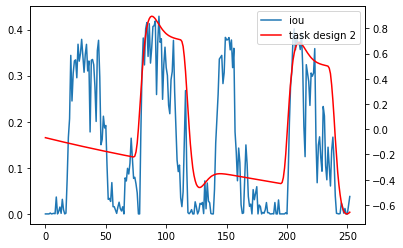

PCC=0.5492277009318675 p=0.00000


In [17]:
tmp2d_2[tmp2d_2 < 0.55] = 0
iou = np.zeros((tmp2d_2.shape[0], template.shape[0]))
for i in range(tmp2d_2.shape[0]):
    for j in range(template.shape[0]):
        iou[i, j] = IoU(template[j:j+1, :], tmp2d_2[i:i+1, :])
for i in range(iou.shape[1]):
    print(i+1)
    line1, = plt.plot(iou[:, i], label="iou")
    plt.twinx()
    line2, = plt.plot(groups.task_design[:, i], color='red', label="task design {}".format(i+1))
    plt.legend(handles=[line1, line2], loc="upper right", labels=["iou", "task design {}".format(i+1)])
    plt.show()
    corr, p = scipy.stats.pearsonr(iou[:, i], groups.task_design[:, i])
    print("PCC={} p={:.5f}".format(corr, p))

In [28]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 500

1


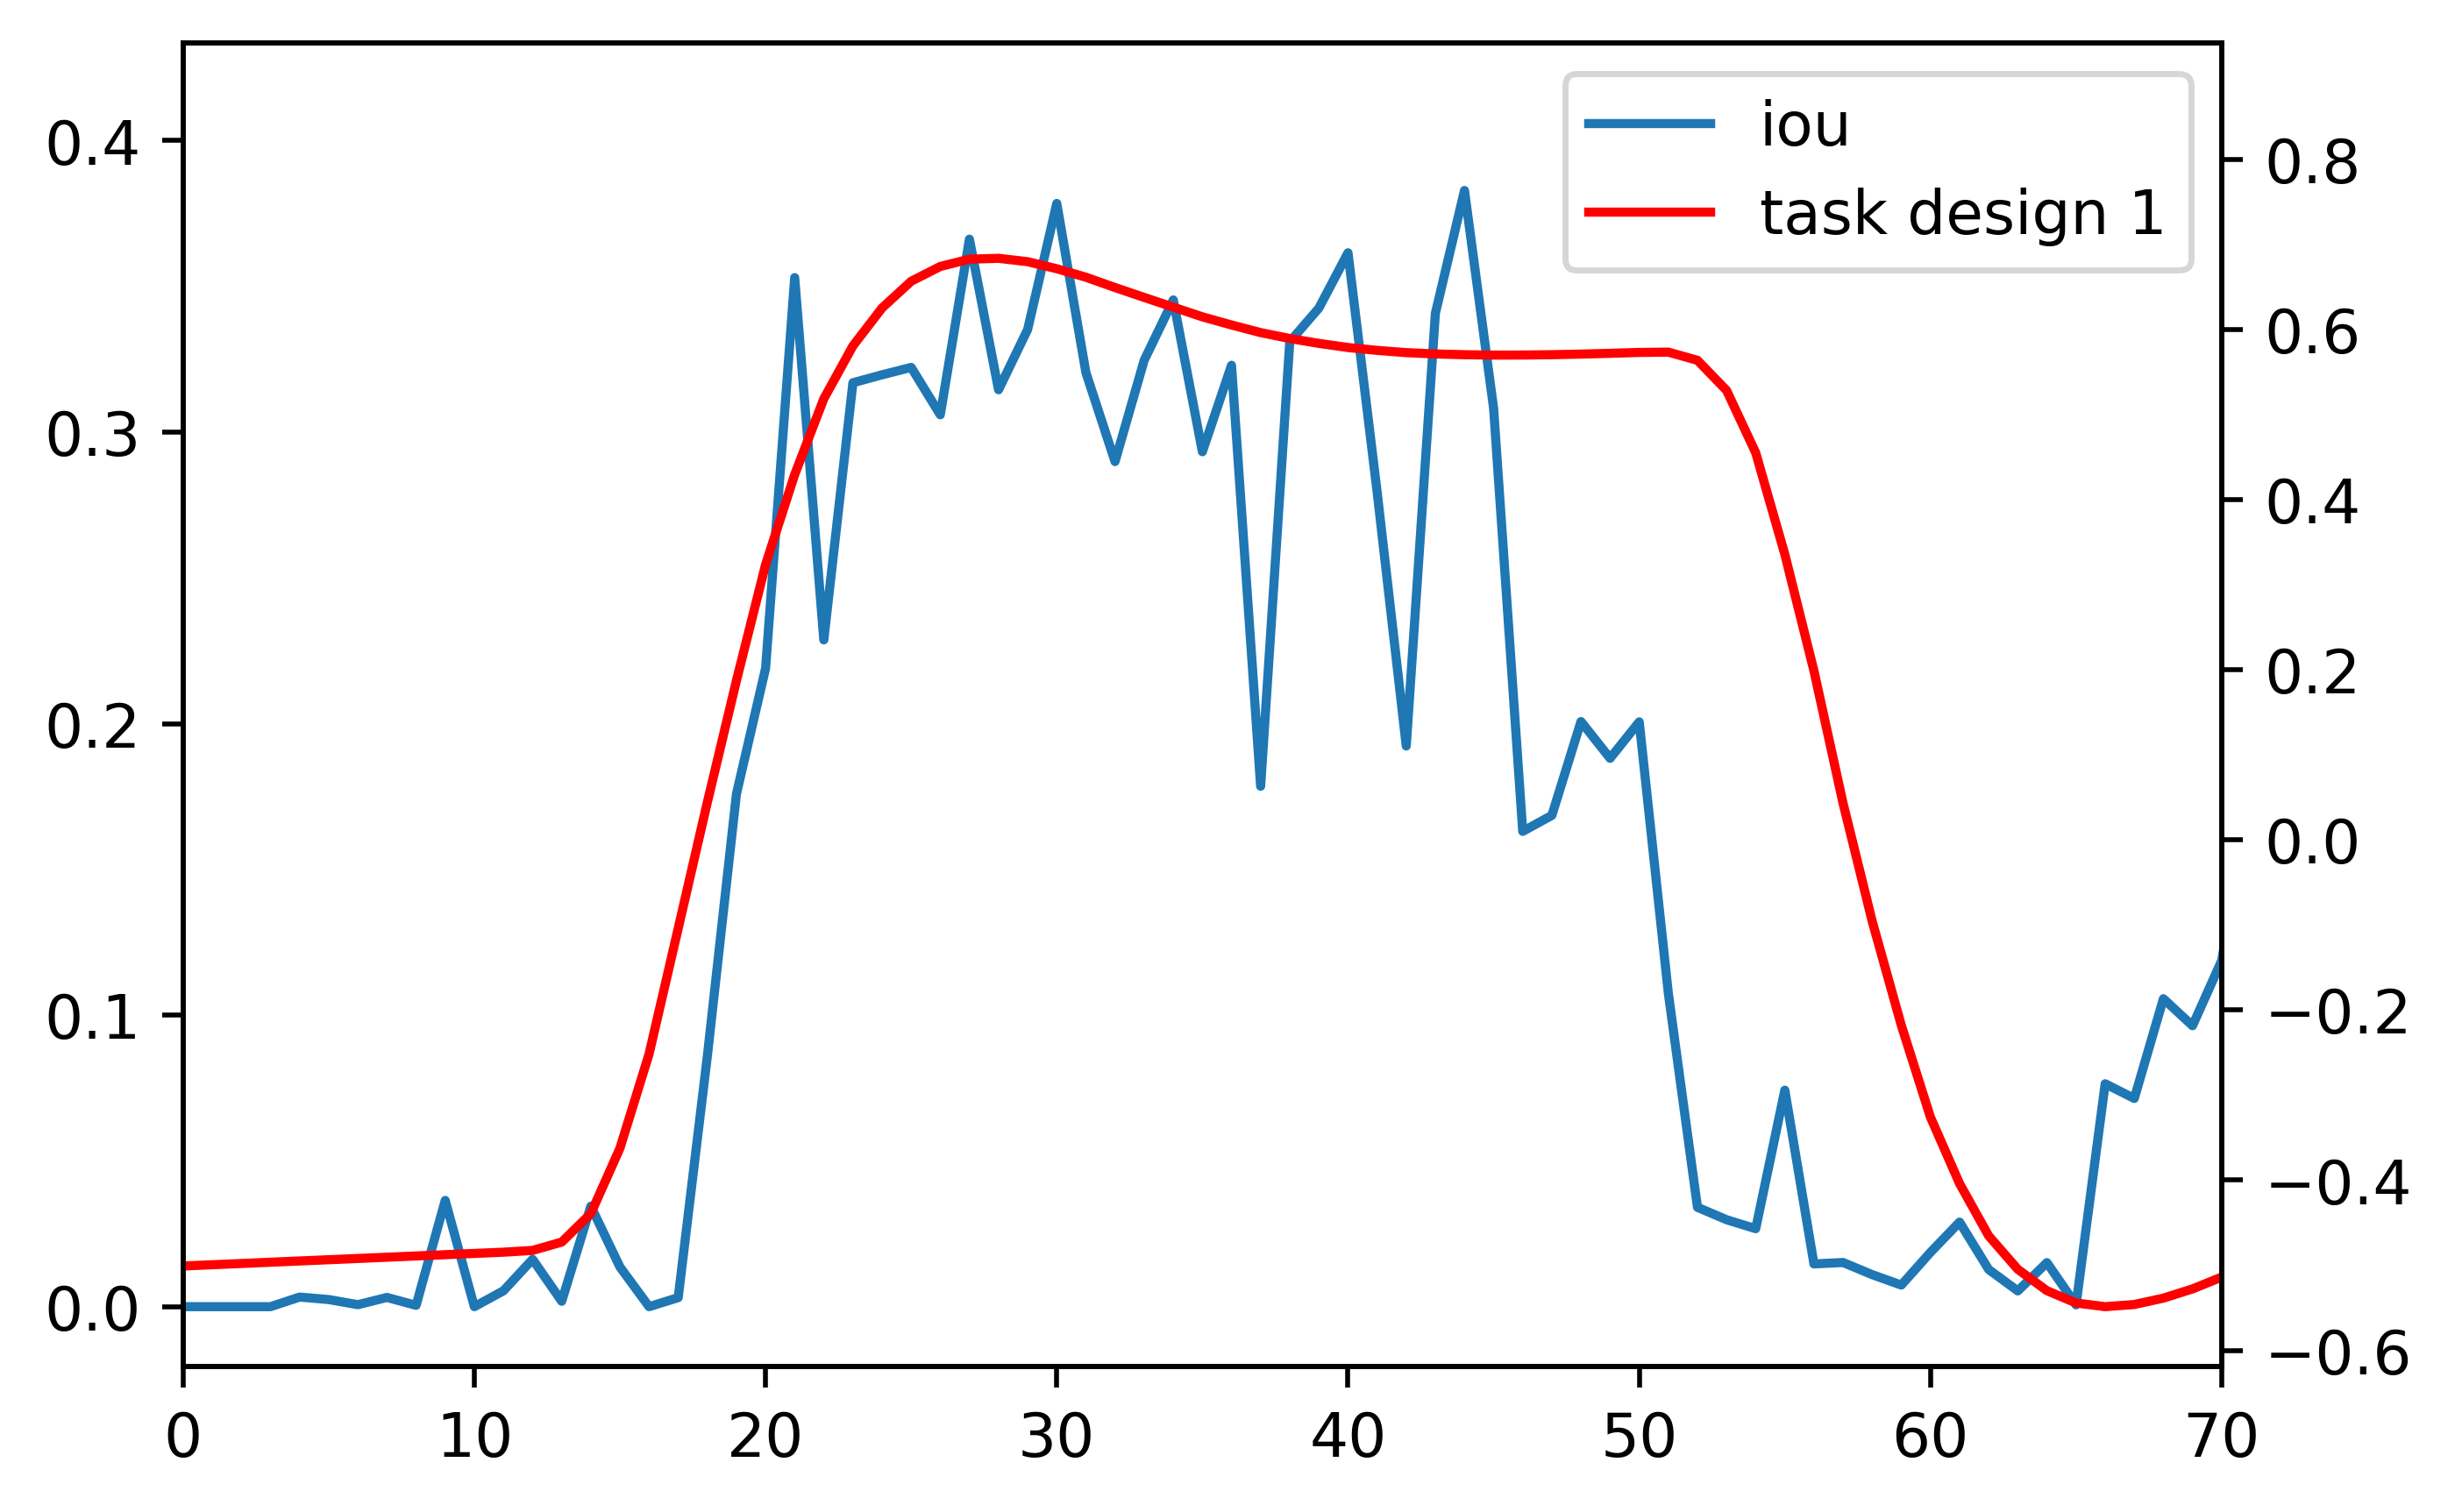

PCC=0.2863710934867678 p=0.00000
2


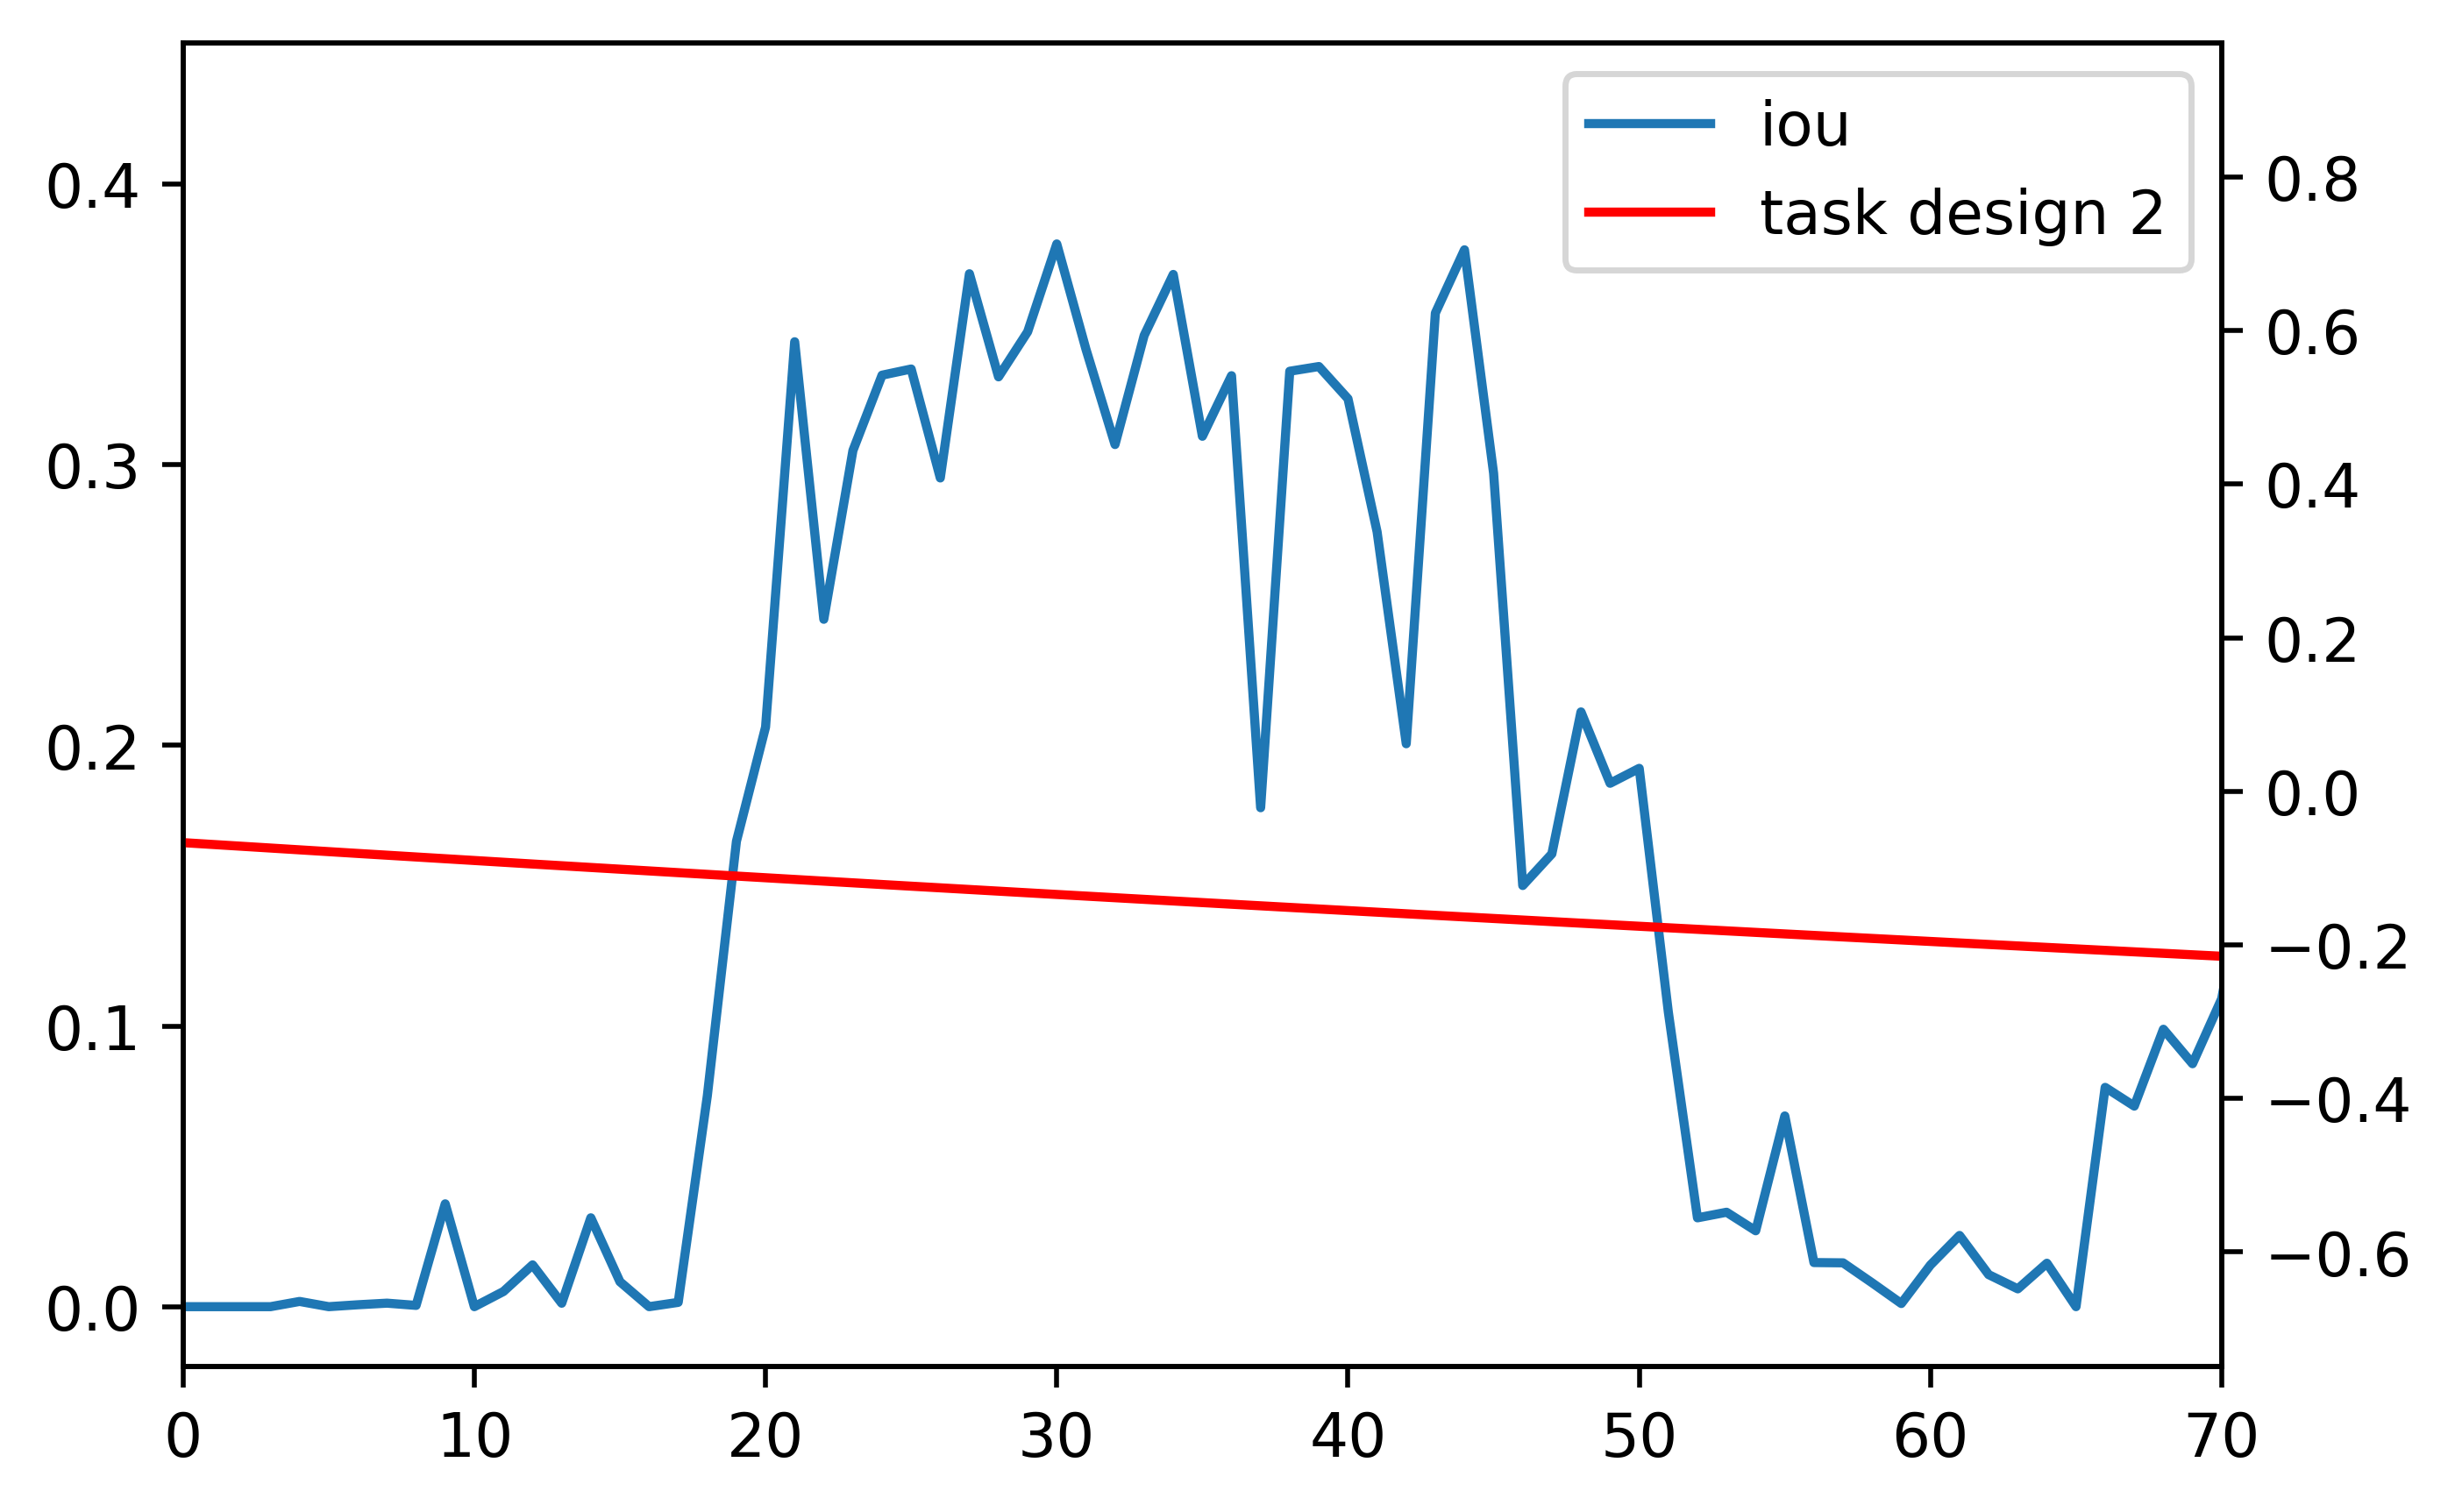

PCC=0.5492277009318675 p=0.00000


In [44]:
for i in range(iou.shape[1]):
    print(i+1)
    line1, = plt.plot(range(iou.shape[0]), iou[:, i], label="iou")
    plt.twinx()
    line2, = plt.plot(range(iou.shape[0]), groups.task_design[:, i], color='red', label="task design {}".format(i+1))
    plt.legend(handles=[line1, line2], loc="upper right", labels=["iou", "task design {}".format(i+1)])
    plt.xlim(0, 70)
    plt.show()
    corr, p = scipy.stats.pearsonr(iou[:, i], groups.task_design[:, i])
    print("PCC={} p={:.5f}".format(corr, p))

In [24]:
def plot_net(img2d):
        components_img = groups.masker.img2NiftImage(img2d)
        for i, cur_img in enumerate(iter_img(components_img)):
            print(i)
            plot_stat_map(cur_img, display_mode="z", title=None,
                          cut_coords=1, colorbar=0, annotate=0, black_bg=1)
            show()

0


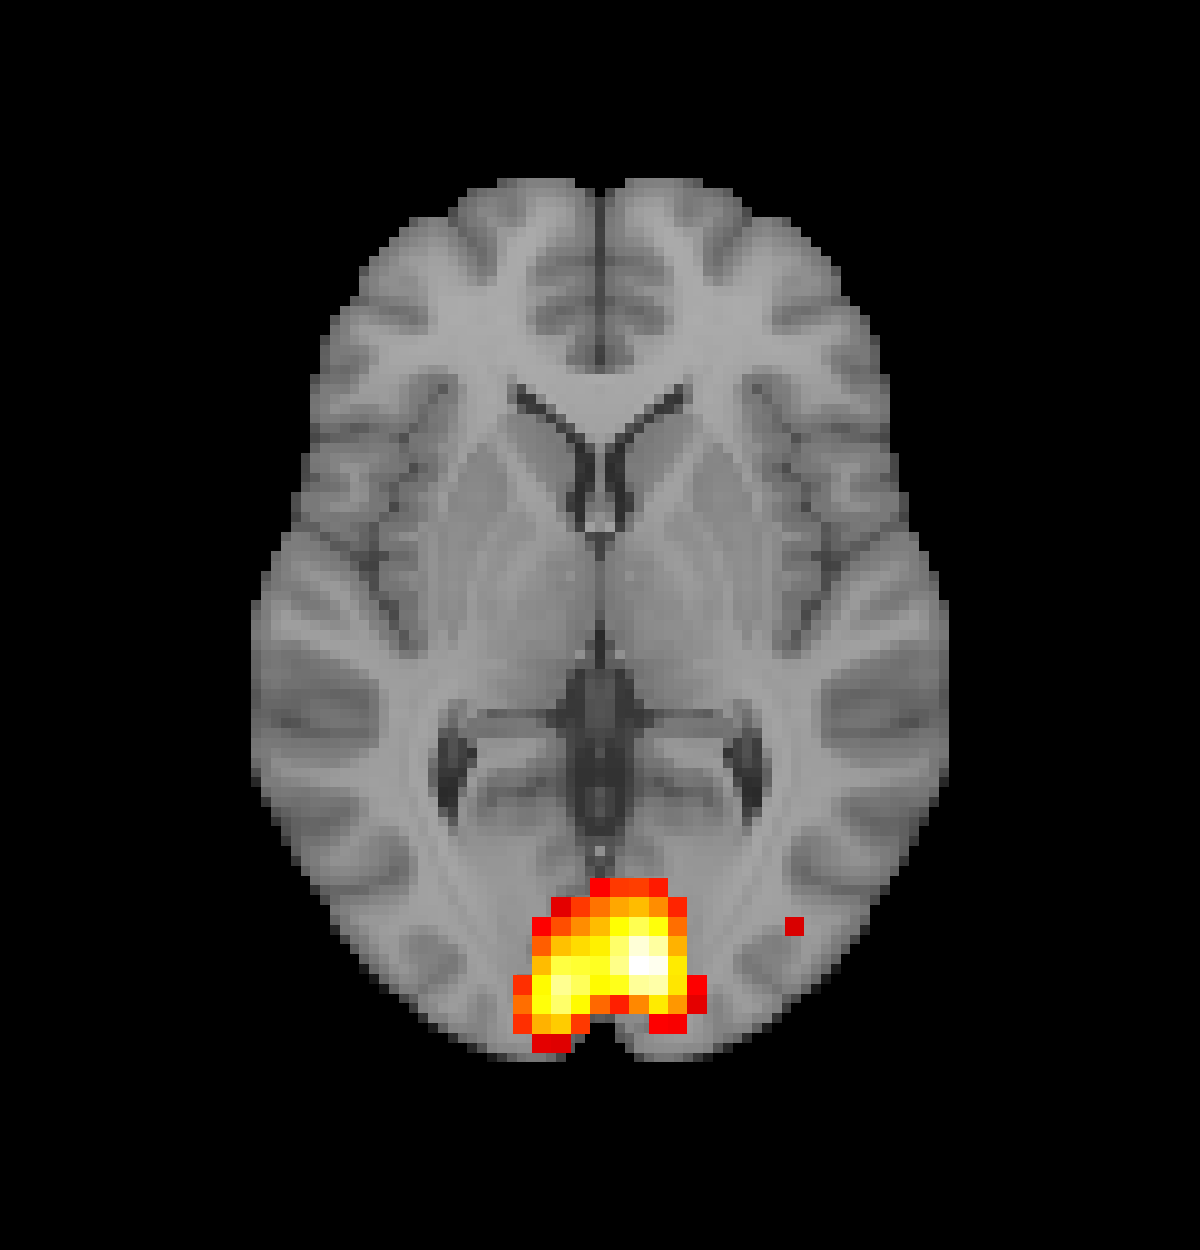

1


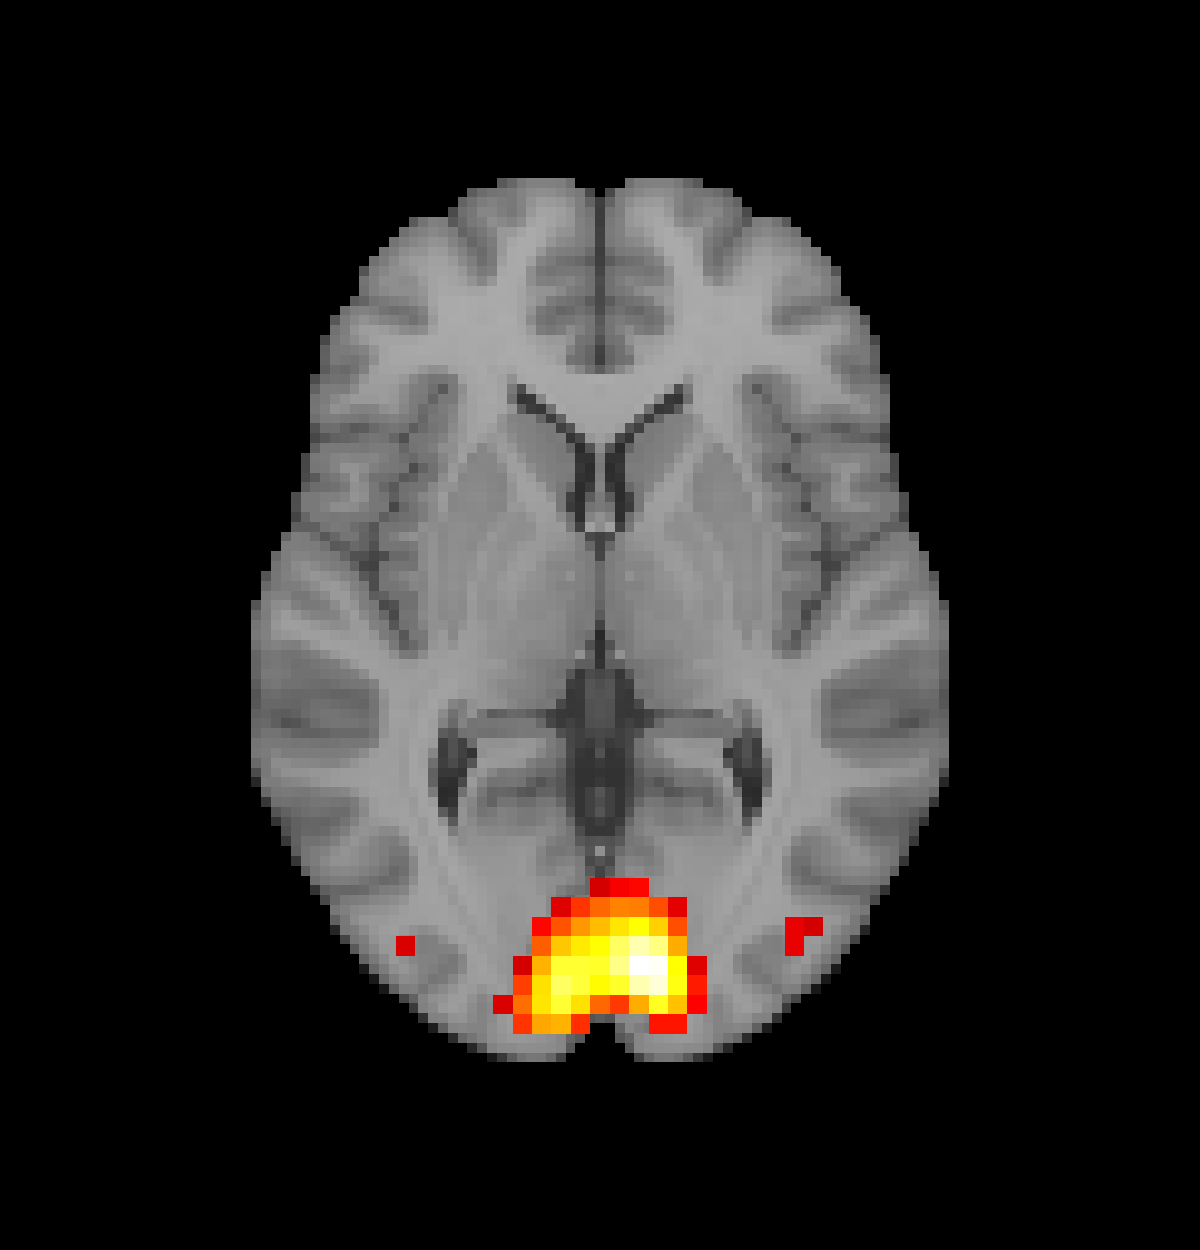

In [32]:
plot_net(template)

0


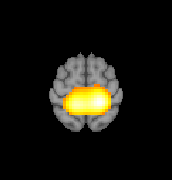

1


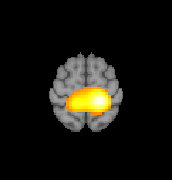

2


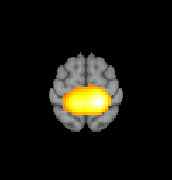

3


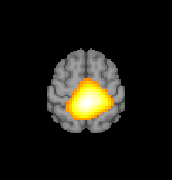

4


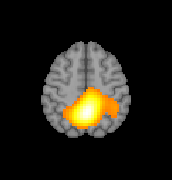

5


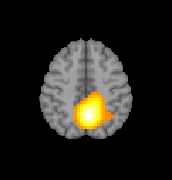

6


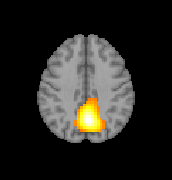

7


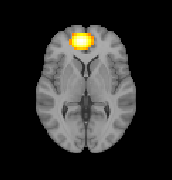

8


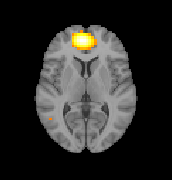

9


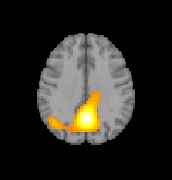

10


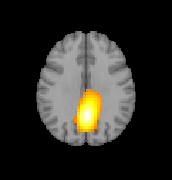

11


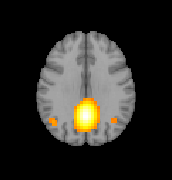

12


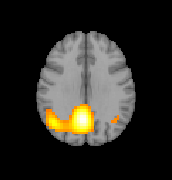

13


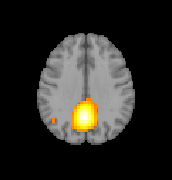

14


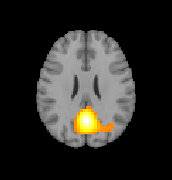

15


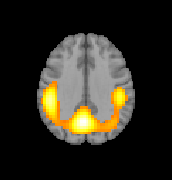

16


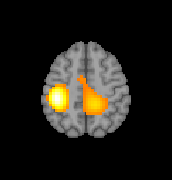

17


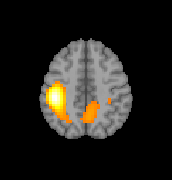

18


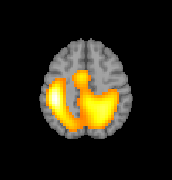

19


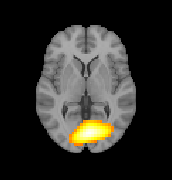

20


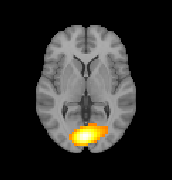

21


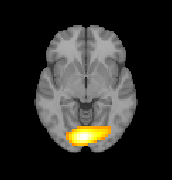

22


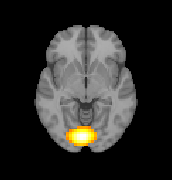

23


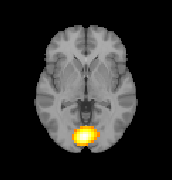

24


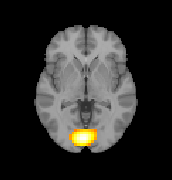

25


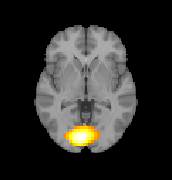

26


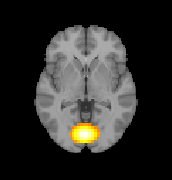

27


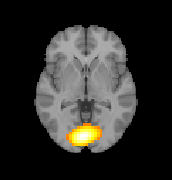

28


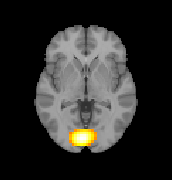

29


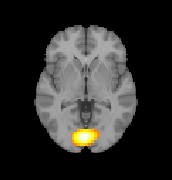

30


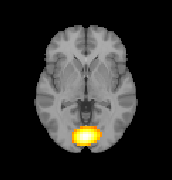

31


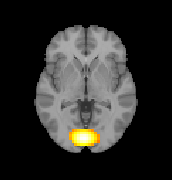

32


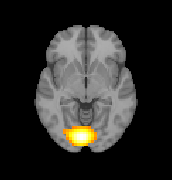

33


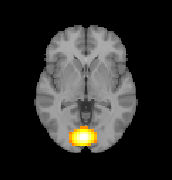

34


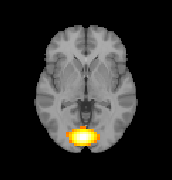

35


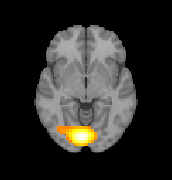

36


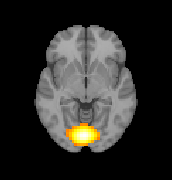

37


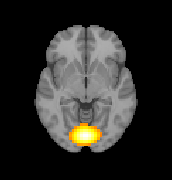

38


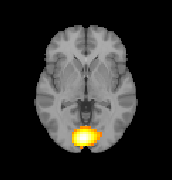

39


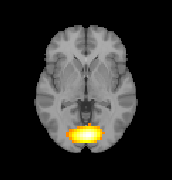

40


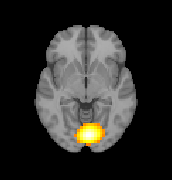

41


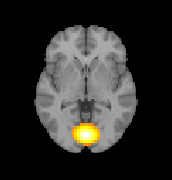

42


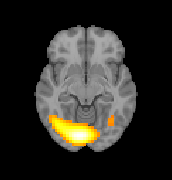

43


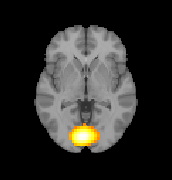

44


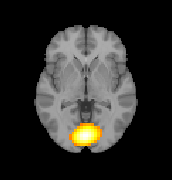

45


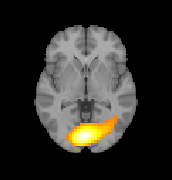

46


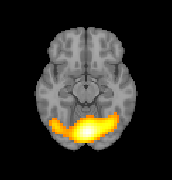

47


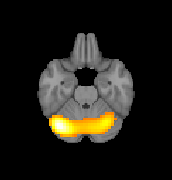

48


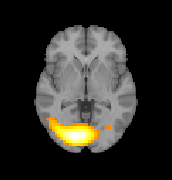

49


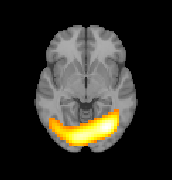

50


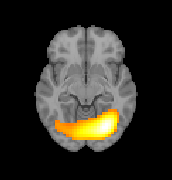

51


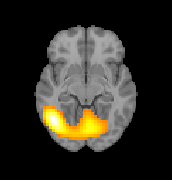

52


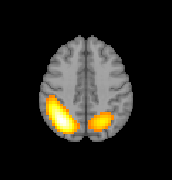

53


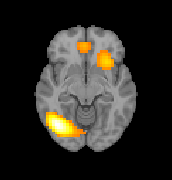

54


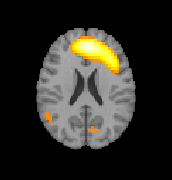

55


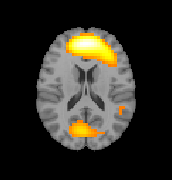

56


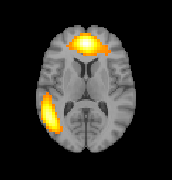

57


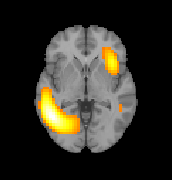

58


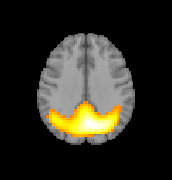

59


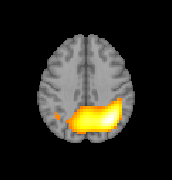

60


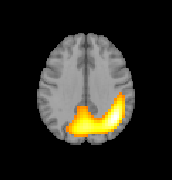

61


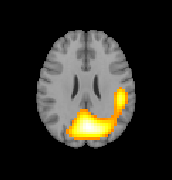

62


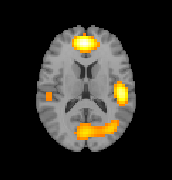

63


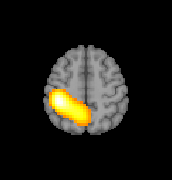

64


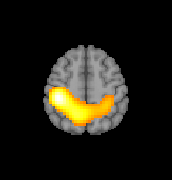

65


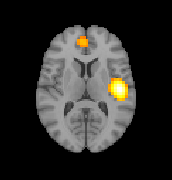

66


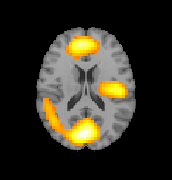

67


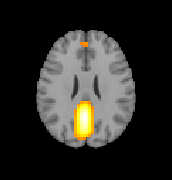

68


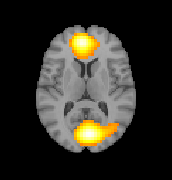

69


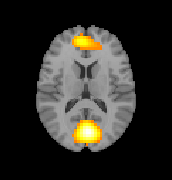

70


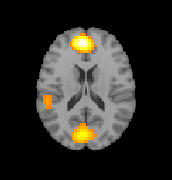

71


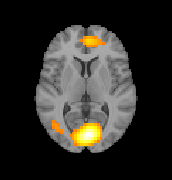

72


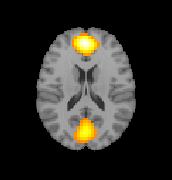

73


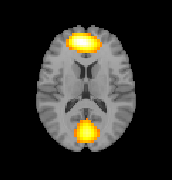

74


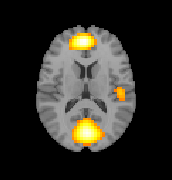

75


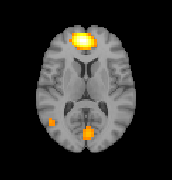

76


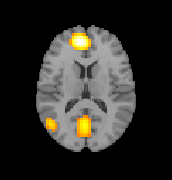

77


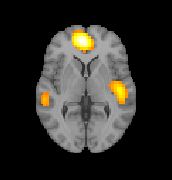

78


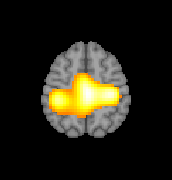

79


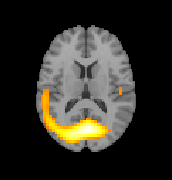

80


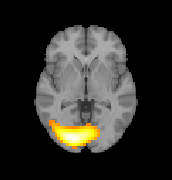

81


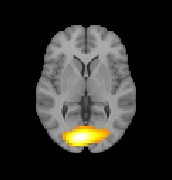

82


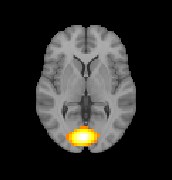

83


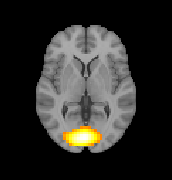

84


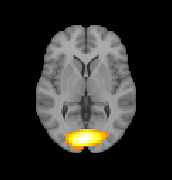

85


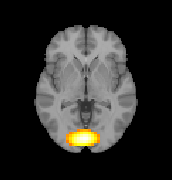

86


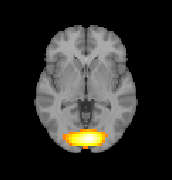

87


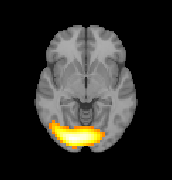

88


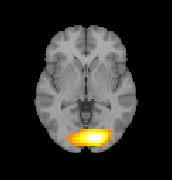

89


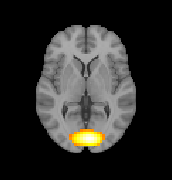

90


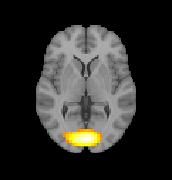

91


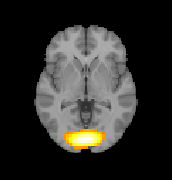

92


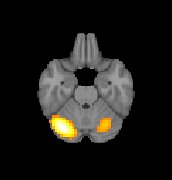

93


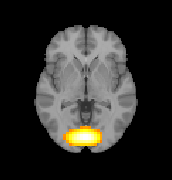

94


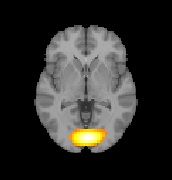

95


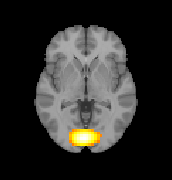

96


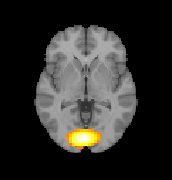

97


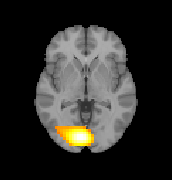

98


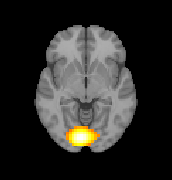

99


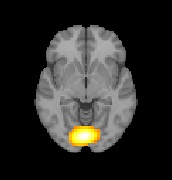

100


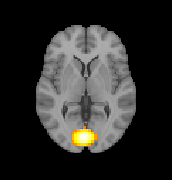

101


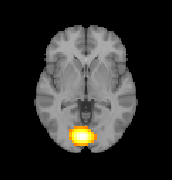

102


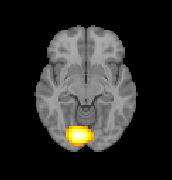

103


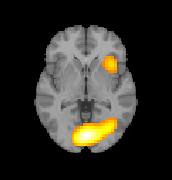

104


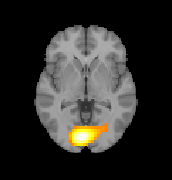

105


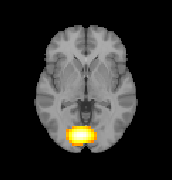

106


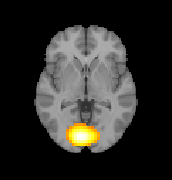

107


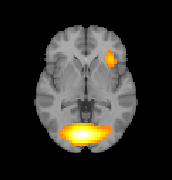

108


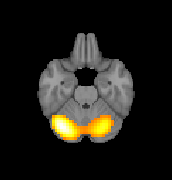

109


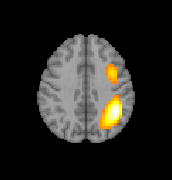

110


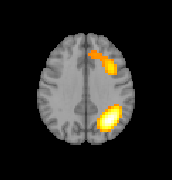

111


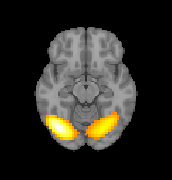

112


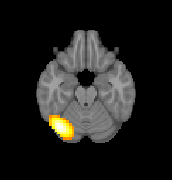

113


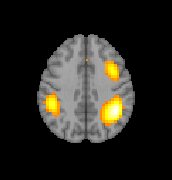

114


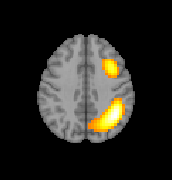

115


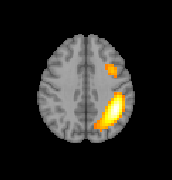

116


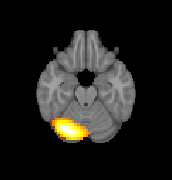

117


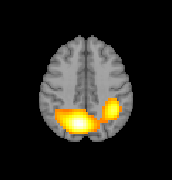

118


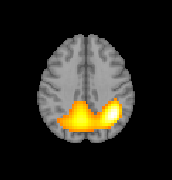

119


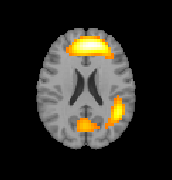

120


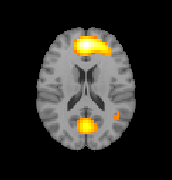

121


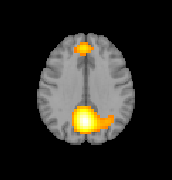

122


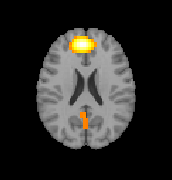

123


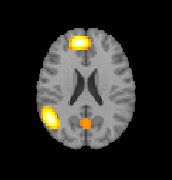

124


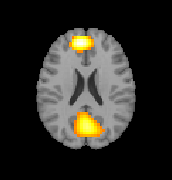

125


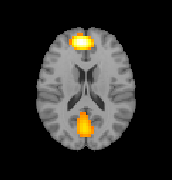

126


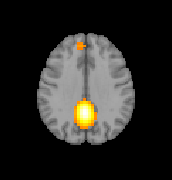

127


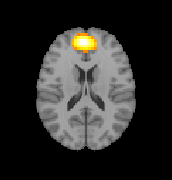

128


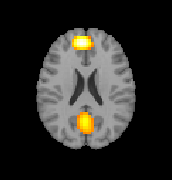

129


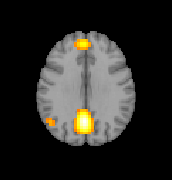

130


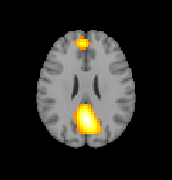

131


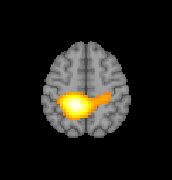

132


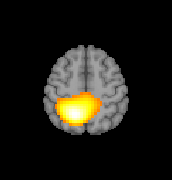

133


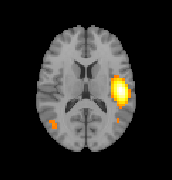

134


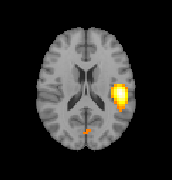

135


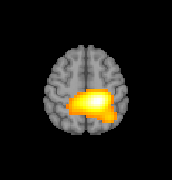

136


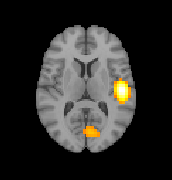

137


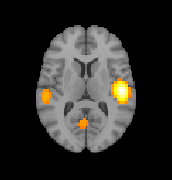

138


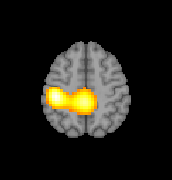

139


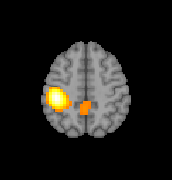

140


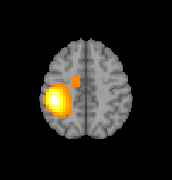

141


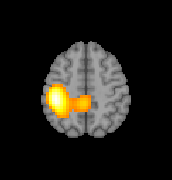

142


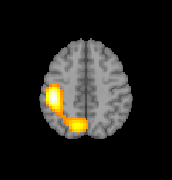

143


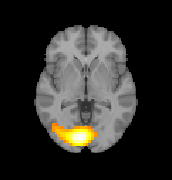

144


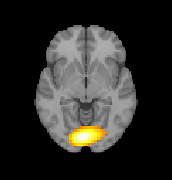

145


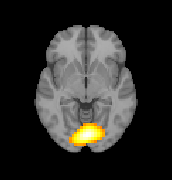

146


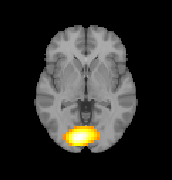

147


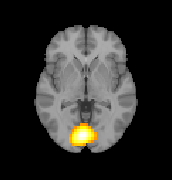

148


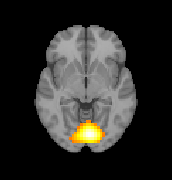

149


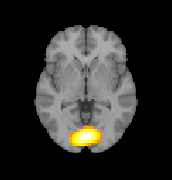

150


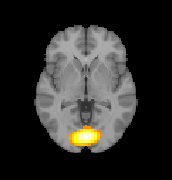

151


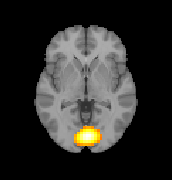

152


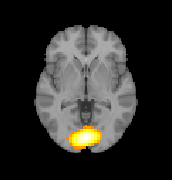

153


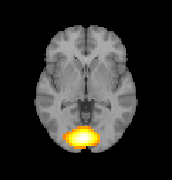

154


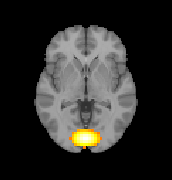

155


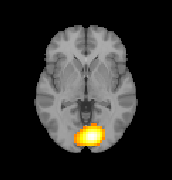

156


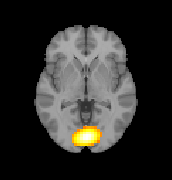

157


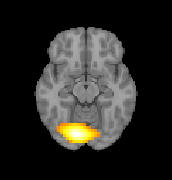

158


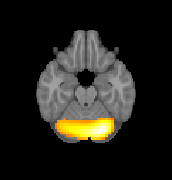

159


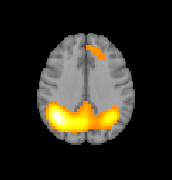

160


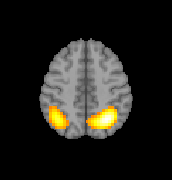

161


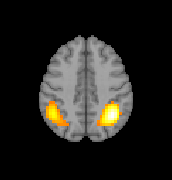

162


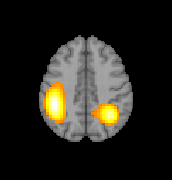

163


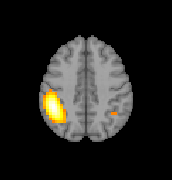

164


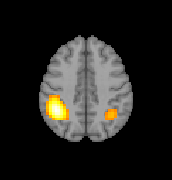

165


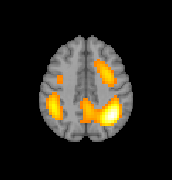

166


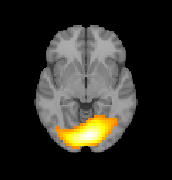

167


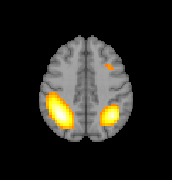

168


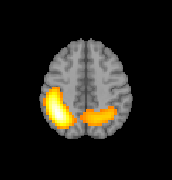

169


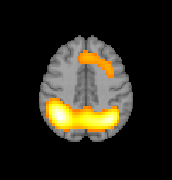

170


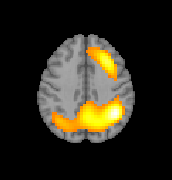

171


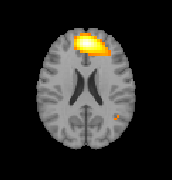

172


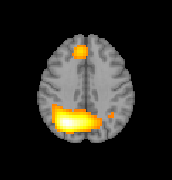

173


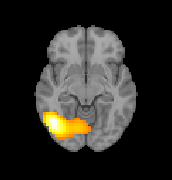

174


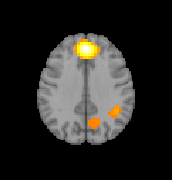

175


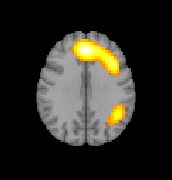

176


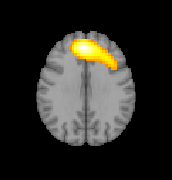

177


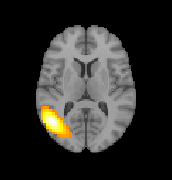

178


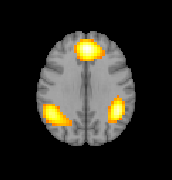

179


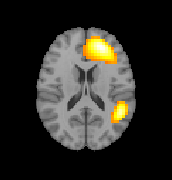

180


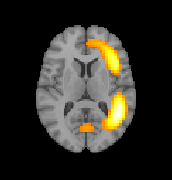

181


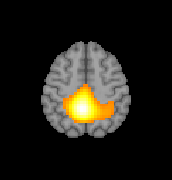

182


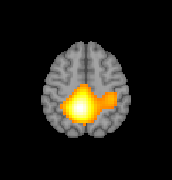

183


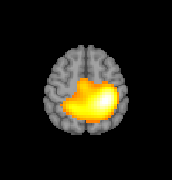

184


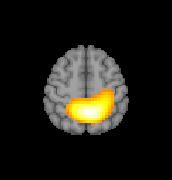

185


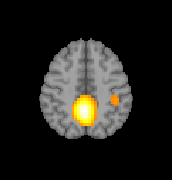

186


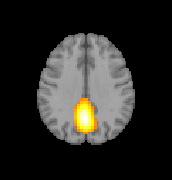

187


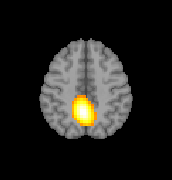

188


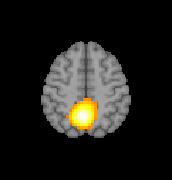

189


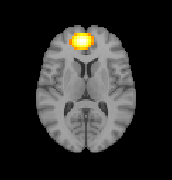

190


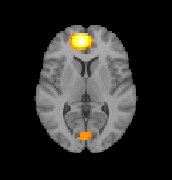

191


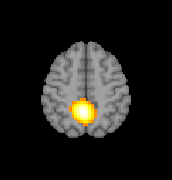

192


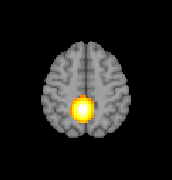

193


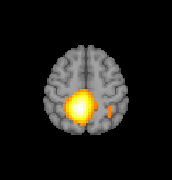

194


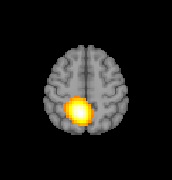

195


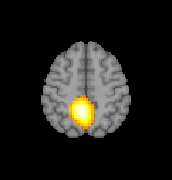

196


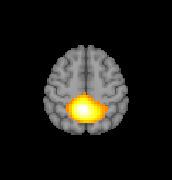

197


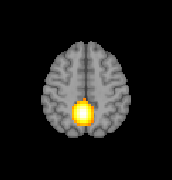

198


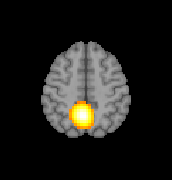

199


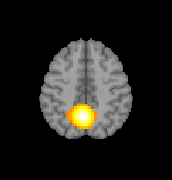

200


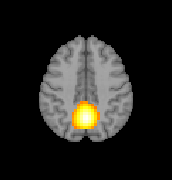

201


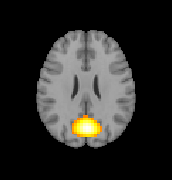

202


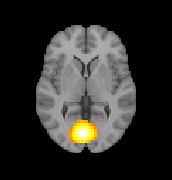

203


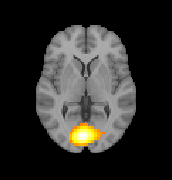

204


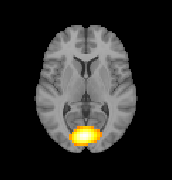

205


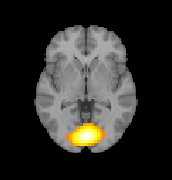

206


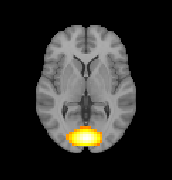

207


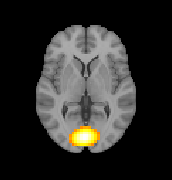

208


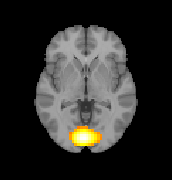

209


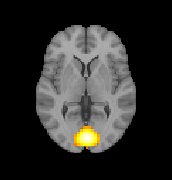

210


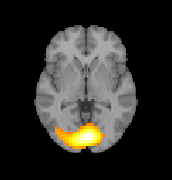

211


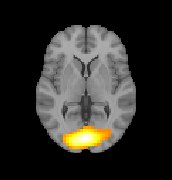

212


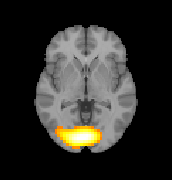

213


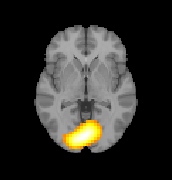

214


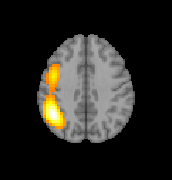

215


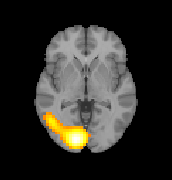

216


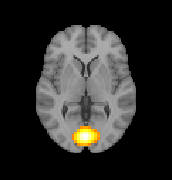

217


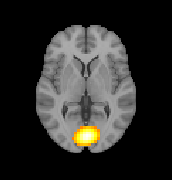

218


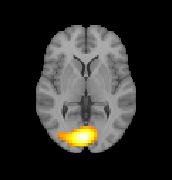

219


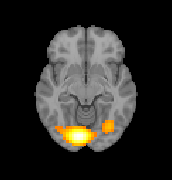

220


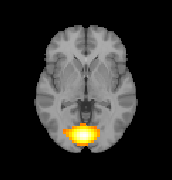

221


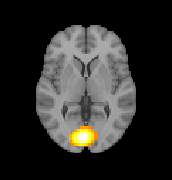

222


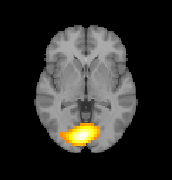

223


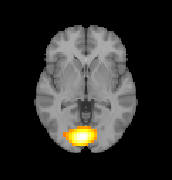

224


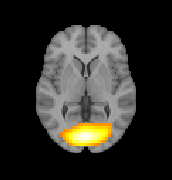

225


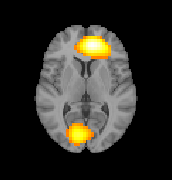

226


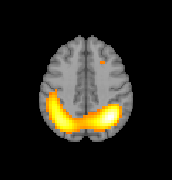

227


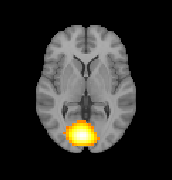

228


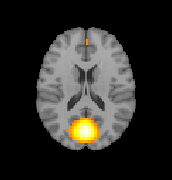

229


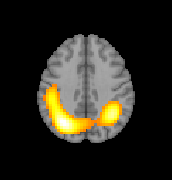

230


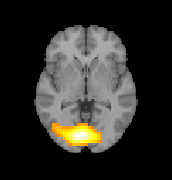

231


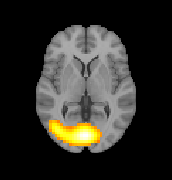

232


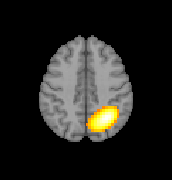

233


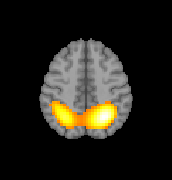

234


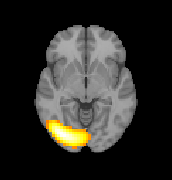

235


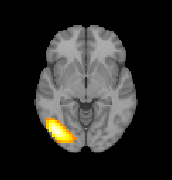

236


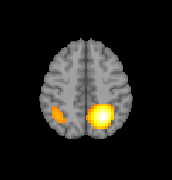

237


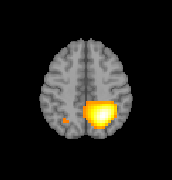

238


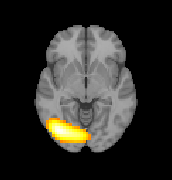

239


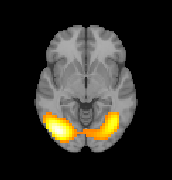

240


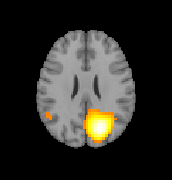

241


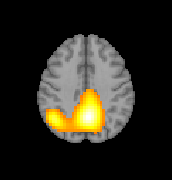

242


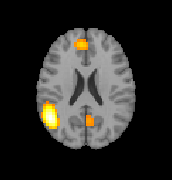

243


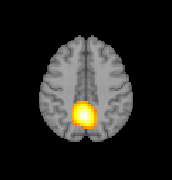

244


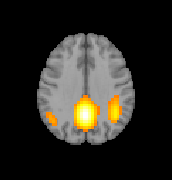

245


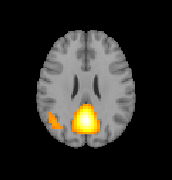

246


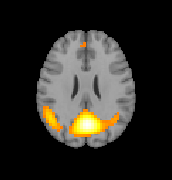

247


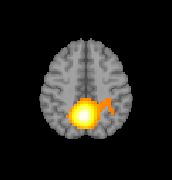

248


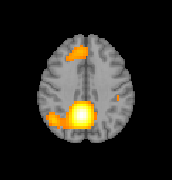

249


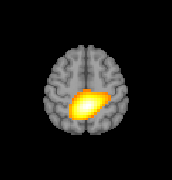

250


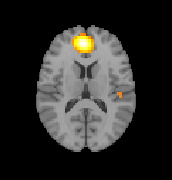

251


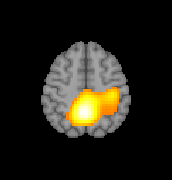

252


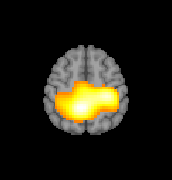

In [25]:
plot_net(tmp2d_2)